In [11]:
import numpy as np
from astropy.io import fits
from scipy.stats import gamma
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
import sys
sys.path.append('../../../2YR-UNI/Blok2/AppStat2019/External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax  
import winsound

In [12]:
# Get COSMOS data
file_name = 'cosmos2015_D17_v2.0_zmin-zmax.fits' #davidzon17 paper

# Data for observed galaxies
hdul = fits.open(file_name)
ra = hdul[1].data["RA_J2000"] # Right ascension
dec = hdul[1].data["DEC_J2000"] # Declination
z = hdul[1].data["ZBEST"] # Redshift
mass = hdul[1].data["logMASS_MED"] # Mass
hdul.close()

In [13]:
# Get CV values from cosmic variance calculator 
# Currently the code is set up to compare to the JADES Deep survey
path = "../CV_Vals/cv_jades_deep.csv"
df = pandas.read_csv(path)
z_vals = df["z"].values
dz_vals = df["dz"].values

In [14]:
# Define a grid of pointings
# Grid of squares with the same size as the JADES Deep survey

##IS JADES Deep a square??????
side1 = 4.8/60
side2= 9.6/60
ra_min = np.min(ra)
dec_min = np.min(dec)
ra_max = np.max(ra)
dec_max = np.max(dec)

ra_vals = np.arange(ra_min, ra_max, side2)
dec_vals = np.flip(np.arange(dec_max, dec_min, -side1))

In [15]:
non=[(7,0),(8,0),(7,1),(8,1),(7,2),(8,2),(7,7),(8,7),(3,8),(2,8),(2,9),(3,9),(6,9),(8,10),(6,10),(2,10),(6,11),(5,12),(1,12),(6,13)]

In [16]:
rade=[]
for i in range(len(non)):
    rade.append((ra_vals[non[i][0]-1],dec_vals[non[i][1]]))

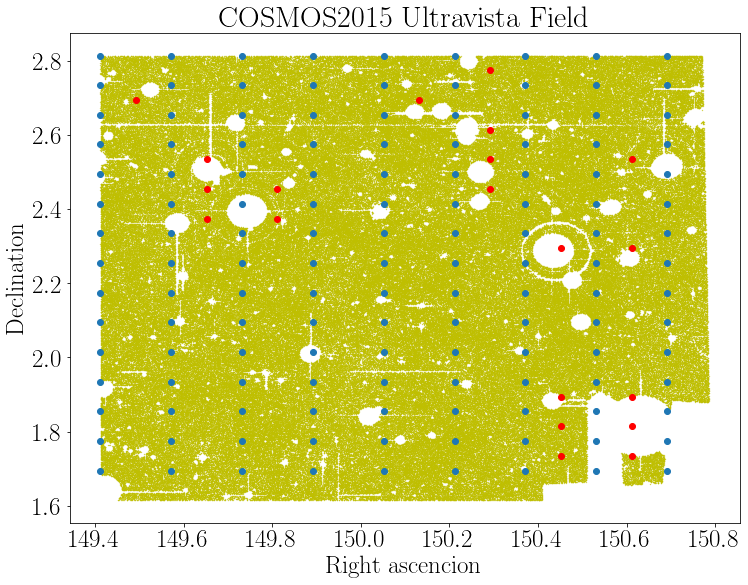

In [17]:
fig, ax=plt.subplots(figsize=(12,9))
ax.scatter(ra,dec,s=0.1,c='y')

x, y = np.meshgrid(ra_vals, dec_vals)
ax.scatter(x,y)
ax.set(xlabel='Right ascencion', ylabel='Declination', title='COSMOS2015 Ultravista Field')
# ax.plot(ra_vals[7],dec_vals[14-12], 'ro')
for i in range(len(ra_vals)-1):
    for j in range(len(dec_vals)-1):
        ra_1 = ra_vals[i]
        dec_1 = dec_vals[j]
        if (ra_1,dec_1) in rade:
            ax.plot(ra_1+side2/2,dec_1+side1/2,'ro')

In [42]:
len(dec_vals)

15

In [18]:
# Find the number of galaxies in each grid cell within a certain z, mass range and compare to gamma distribution
def num_gals(z_val, dz_val, m, trials=1e6, plot=False, close=True, save=False):
    sig = df.loc[df['z'] == z_val][[str(m)]].values[0][0]
    # Define z range
    min_z = z_val - dz_val/2
    max_z = z_val + dz_val/2

    num_gal = []
    
    # Find number of galaxies in each cell within z, mass range
    for i in range(len(ra_vals)-1):
        for j in range(len(dec_vals)-1):
            ra_1 = ra_vals[i]
            dec_1 = dec_vals[j]
            ra_2 = ra_1 + side2
            dec_2 = dec_1 + side1
            if (ra_1,dec_1) not in rade:
                index = np.where((ra > ra_1) & (ra < ra_2) & (dec > dec_1) & (dec < dec_2) & (z < max_z) & (z > min_z)
                                & (mass > m) & (mass < m + 0.5))
                num_gal.append(len(z[index]))
    # Compare distribution of high z galaxies to gamma distribution
    if any(num_gal):
        vals, counts = np.unique(num_gal, return_counts=True)
        
        # TO DO: Fix bug in gamma distribution mean.
        # There is currently an issue where the mean of the true distribution and the gamma distrbution do not match
        # despite being assigned as the same value. This may arise from when the gamma distribution is integrated.
        
        # TO DO: Update this mean to reflect the luminosity function used in the mean-median calculations.
        
        mean = np.mean(num_gal) # Use the mean number of galaxies from the COSMOS data set as the mean of the distribution.
        
        var = sig**2*mean**2 # Calculate variance from the cosmic variance calculator values
        k = mean**2/var
        t = var/mean
        
        
        # Normalize gamma distribution, COSMOS data
        err=np.sqrt(counts) / np.sum(counts)
        counts_nn=counts
        counts = counts / np.sum(counts)
#         print('gamma mean/var is {}, {}'.format(gamma.stats(k, scale=t, moments='m'),gamma.stats(k,scale=t, moments='v')))
#         print('True mean/var is {}, {}'.format(mean,var))
#         print('{}'.format(k*t))
        # Plot to compare true and simulated distribution
        
        if(plot):
            fig, ax = plt.subplots(figsize = (12, 9))
            ax.plot(x,rv.pdf(x), 'ro-', label='straight pdf')
            ax.plot(x,gamma_int,'bo-',label="Gamma Distribution",marker = "o", markersize = 5)
            ax.plot(vals,counts, 'ro', label="COSMOS2015")
            ax.errorbar(vals,counts, yerr=err, c = 'k', elinewidth = 1, \
                           capsize = 2, ls = 'none')
            xtick=np.arange(0,max(num_gal)+2,2)
            ax.set(xticks=xtick, xlabel="Number of Galaxies", ylabel="Fraction of Pointings", title="46"r"$arcmin^2$ ""pointing, z = %.3f, Mass %.1f-%.1f "r"$M_{\odot}$" % (z_val, m, m+0.5))
            plt.legend()

            if save==True:
                plt.savefig("figs/CV_z%.3f_m%.1f.pdf" % (z_val, m))
            if close==True:
                plt.close()
        g=np.random.gamma(k, scale=t, size=int(trials))
    return x, vals, counts, err, g, counts_nn, mean, var, num_gal

In [46]:
%matplotlib inline
# change x-ticks to be in the middle of the histogram
# Generate all plots
plt.rcParams.update({'font.size': 12})
# %time
indices = np.arange(40,60)
masses = [8.5, 9.0, 9.5, 10.0, 10.5, 11.0]
print(len(indices)*len(masses),'panels. Expected time is {} s'.format(len(indices)*len(masses)*12.5))
# fig, ax = plt.subplots(nrows=len(masses),ncols=len(indices), figsize = (23,29.7))
# fig.set(xlabel='Number of Galaxies', ylabel='Fraction of points')
# plt.rcParams.update({'font.size': 35})
# fig.text(0.5, 0.095, 'Number of galaxies', ha='center')
# fig.text(0.08, 0.5, 'Fraction of Pointings', va='center', rotation='vertical')
# plt.rcParams.update({'font.size': 15})
chi_list=[]
k=0
for i in indices:
    j=0
    for m in masses:
        z_val = z_vals[i]
        dz_val = dz_vals[i]
        x, vals, counts, err, g, counts_nn, mean, var, num_gal = num_gals(z_val, dz_val, m, plot=False, close=False)
        me=np.mean(g)
        std=np.std(g)
        g = g[g <= max(vals)+1]
        y, bin_edges=np.histogram(g,bins=np.arange(max(vals)+3),range=(0,max(vals)+3),density=1)
        x_val=np.arange(len(y))
        count_f=np.zeros(len(y))
        chi2=0
        for t in range(len(y)):
            if x_val[t] in vals:
                q=np.where(vals==x_val[t])
                chi2+=(counts[q]-y[t])**2/err[q]**2
        chi2=chi2/len(vals)
        chi_list.append(chi2)
        print(i)
        j+=1
    k+=1
# fig.tight_layout()
duration = 250  # milliseconds
freq = 500  # Hz
winsound.Beep(freq, duration)

120 panels. Expected time is 1500.0 s
40
40
40
40
40
40
41
41
41
41
41
41
42
42
42
42
42
42
43
43
43
43
43
43
44
44
44
44
44
44
45
45
45
45
45
45
46
46
46
46
46
46
47
47
47
47
47
47
48
48
48
48
48
48
49
49
49
49
49
49
50
50
50
50
50
50
51
51
51
51
51
51
52
52
52
52
52
52
53
53
53
53
53
53
54
54
54
54
54
54
55
55
55
55
55
55
56
56
56
56
56
56
57
57
57
57
57
57
58
58
58
58
58
58
59
59
59
59
59
59


1.2400171460622116

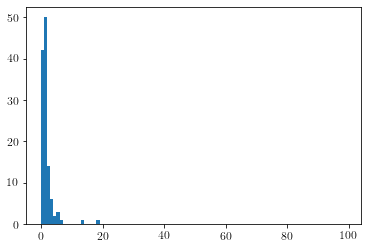

In [68]:
chi_list=np.array(chi_list).flatten()
fig, ax = plt.subplots()
ax.hist(chi_list, bins=np.arange(100))
# np.percentile(chi_list)
np.median(chi_list)

In [79]:
np.mean(chi_list), np.median(chi_list)

(2.1417613390646455, 1.3281869528337726)

In [75]:
# chi_list=chi_list[6*8:]

In [76]:
np.mean(chi_list[:int(len(chi_list)/2)]), np.median(chi_list[:int(len(chi_list)/2)]), np.mean(chi_list[int(len(chi_list)/2):]), np.median(chi_list[int(len(chi_list)/2):])

(2.655220863133265, 1.7050777916713666, 1.6283018149960247, 1.230490247179017)

In [69]:
np.sort(chi_list)

array([ 0.16571086,  0.19771399,  0.22790019,  0.23867244,  0.32815931,
        0.37341316,  0.38603295,  0.38980057,  0.41630777,  0.46813155,
        0.48478988,  0.48510022,  0.51675456,  0.54532951,  0.568743  ,
        0.5760894 ,  0.58341722,  0.58821407,  0.66485226,  0.69399874,
        0.6994353 ,  0.70275554,  0.70305751,  0.76017414,  0.76644077,
        0.77671494,  0.77899932,  0.79357826,  0.80072789,  0.81687693,
        0.84172683,  0.84644883,  0.84684353,  0.86292075,  0.89485742,
        0.89552771,  0.89906055,  0.91213083,  0.91537703,  0.94181296,
        0.95503216,  0.99648108,  1.01137908,  1.02222222,  1.02300379,
        1.02553511,  1.02800162,  1.0292144 ,  1.03214586,  1.08361896,
        1.09889788,  1.10121918,  1.10253711,  1.17702337,  1.17733687,
        1.17923826,  1.19254316,  1.19414388,  1.22046359,  1.23951739,
        1.24051691,  1.26871091,  1.29549422,  1.30666472,  1.31635493,
        1.34001898,  1.34350524,  1.34663369,  1.3639991 ,  1.38

18 panels. Expected time is 225.0 s


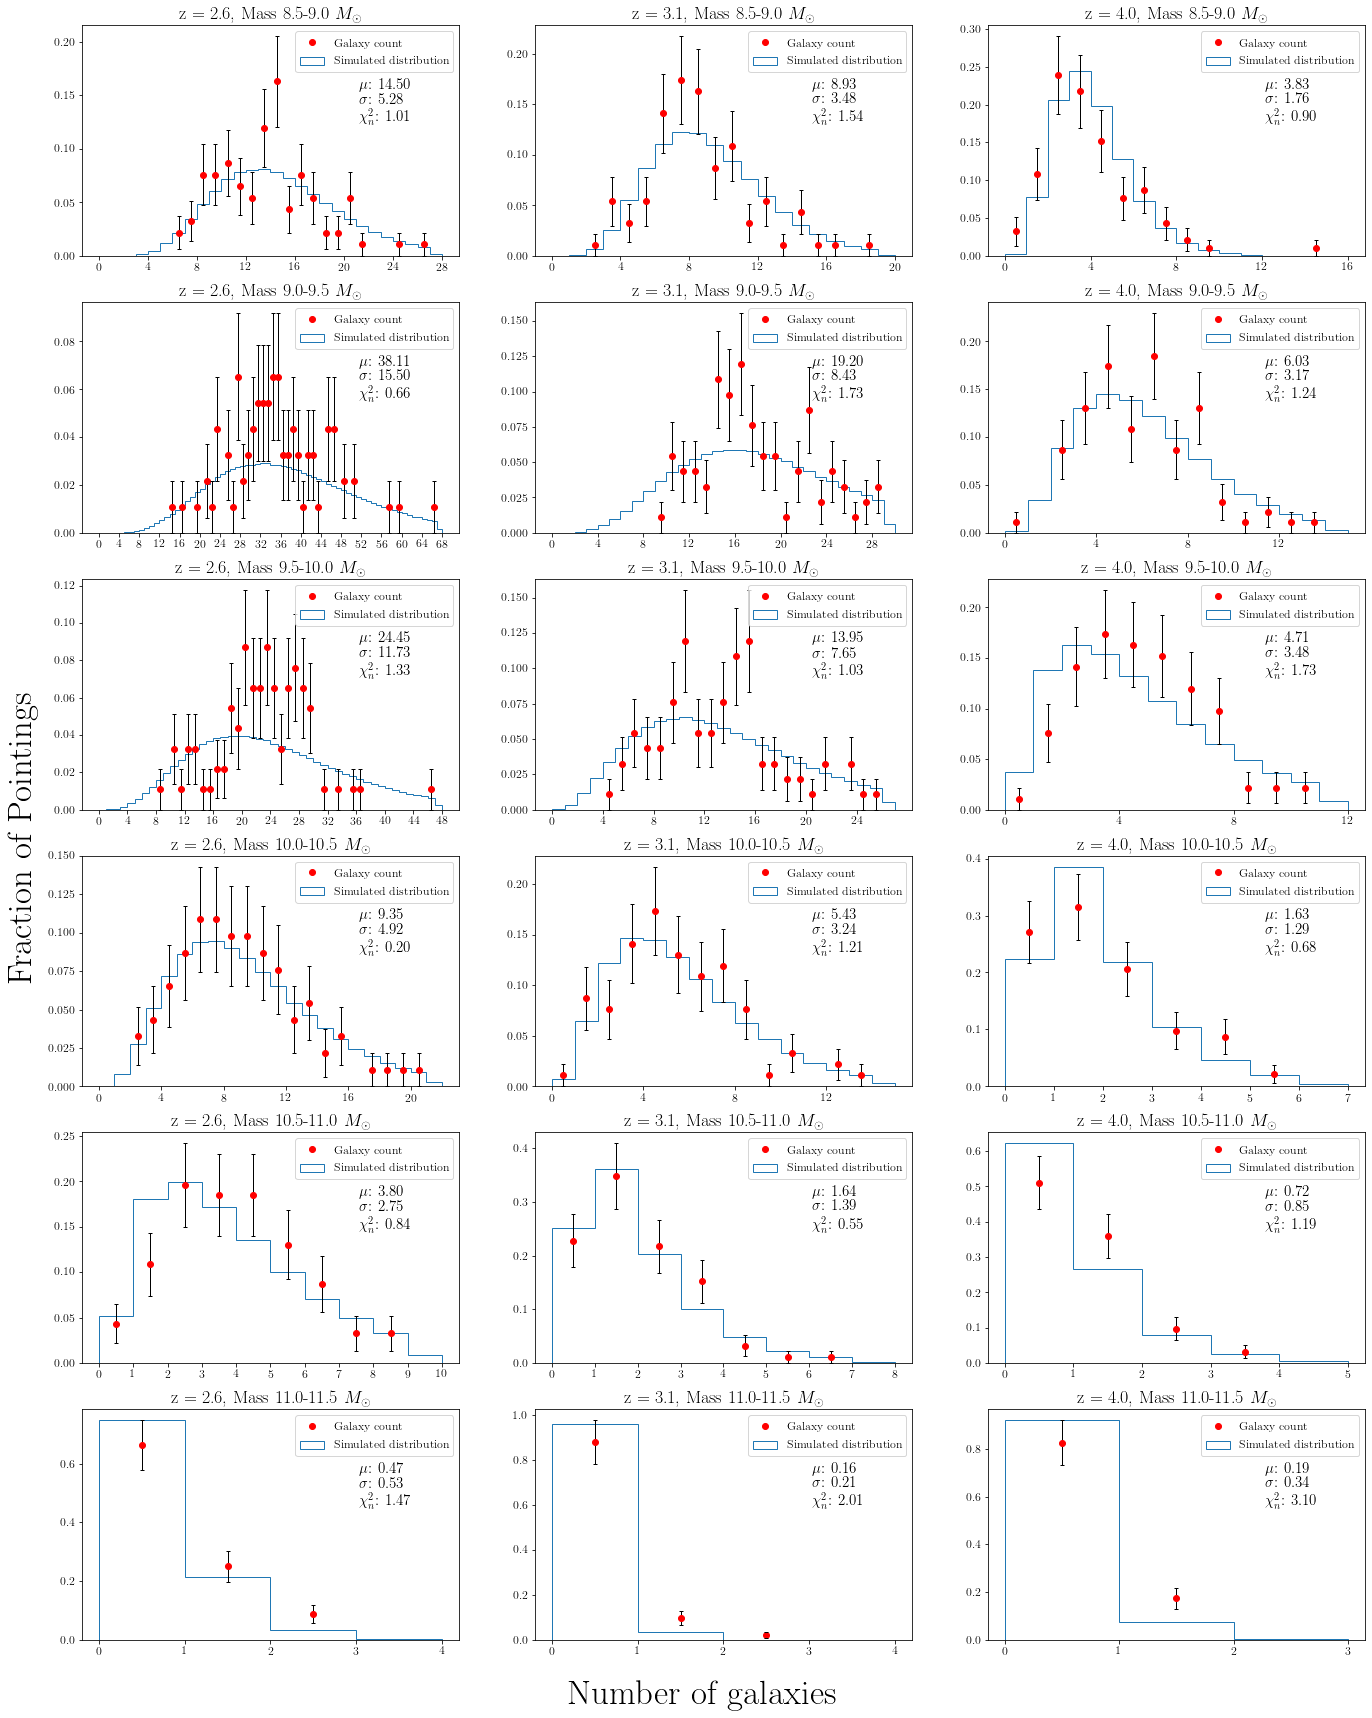

In [34]:
%matplotlib inline
# change x-ticks to be in the middle of the histogram
# Generate all plots
plt.rcParams.update({'font.size': 12})
# %time
indices = [40,43,48,52,55,59]
masses = [8.5, 9.0, 9.5, 10.0, 10.5, 11.0]
indices=indices[:3]
print(len(indices)*len(masses),'panels. Expected time is {} s'.format(len(indices)*len(masses)*12.5))
fig, ax = plt.subplots(nrows=len(masses),ncols=len(indices), figsize = (23,29.7))
# fig.set(xlabel='Number of Galaxies', ylabel='Fraction of points')
plt.rcParams.update({'font.size': 35})
fig.text(0.5, 0.095, 'Number of galaxies', ha='center')
fig.text(0.08, 0.5, 'Fraction of Pointings', va='center', rotation='vertical')
plt.rcParams.update({'font.size': 15})
k=0
for i in indices:
    j=0
    for m in masses:
        z_val = z_vals[i]
        dz_val = dz_vals[i]
        x, vals, counts, err, g, counts_nn, mean, var, num_gal = num_gals(z_val, dz_val, m, plot=False, close=False)
        me=np.mean(g)
        std=np.std(g)
        g = g[g <= max(vals)+1]
        y, bin_edges, patch=ax[j][k].hist(g+0.3,bins=np.arange(max(vals)+3),range=(0,max(vals)+3),density=1,histtype='step', label='Simulated distribution')
        x_val=np.arange(len(y))
        count_f=np.zeros(len(y))
        chi2=0
        for t in range(len(y)):
            if x_val[t] in vals:
                q=np.where(vals==x_val[t])
                chi2+=(counts[q]-y[t])**2/err[q]**2
        chi2=chi2/len(vals)
        d = {r'$\mu$:': mean,
             r'$\sigma$:': np.sqrt(var),
             r'$\chi^2_n$:': chi2[0] ,
            }        
        text = nice_string_output(d, extra_spacing=2, decimals=2)
        add_text_to_ax(0.735, 0.77, text, ax[j][k], fontsize=15)
#         add_text_to_ax(0.7, 0.7, text, ax[k][j], fontsize=25)
        ax[j][k].plot(vals+0.5,counts, 'ro', label='Galaxy count') 
        ax[j][k].errorbar(vals+0.5,counts, yerr=err, c = 'k', elinewidth = 1, \
                       capsize = 2, ls = 'none')
        if max(vals)>=10:
            xtick=np.arange(0,max(vals)+3,4)
        else:
            xtick=np.arange(0,max(vals)+3,1)
        z_val = z_vals[i]
        ax[j][k].set(xticks=xtick, title="z = %.1f, Mass %.1f-%.1f "r"$M_{\odot}$" % (np.round(z_val,2), m, m+0.5))
#         ax[k][j].set(xticks=xtick, xlabel="Number of Galaxies", ylabel="Fraction of Pointings", title="z = %.1f, Mass %.1f-%.1f "r"$M_{\odot}$" % (np.round(z_val,2), m, m+0.5))
        ax[j][k].legend(loc=1, prop={'size': 12})
        j+=1
    k+=1
# fig.tight_layout()
duration = 250  # milliseconds
freq = 500  # Hz
winsound.Beep(freq, duration)
plt.savefig('test_cosmos_full_1.pdf')

18 panels. Expected time is 225.0 s


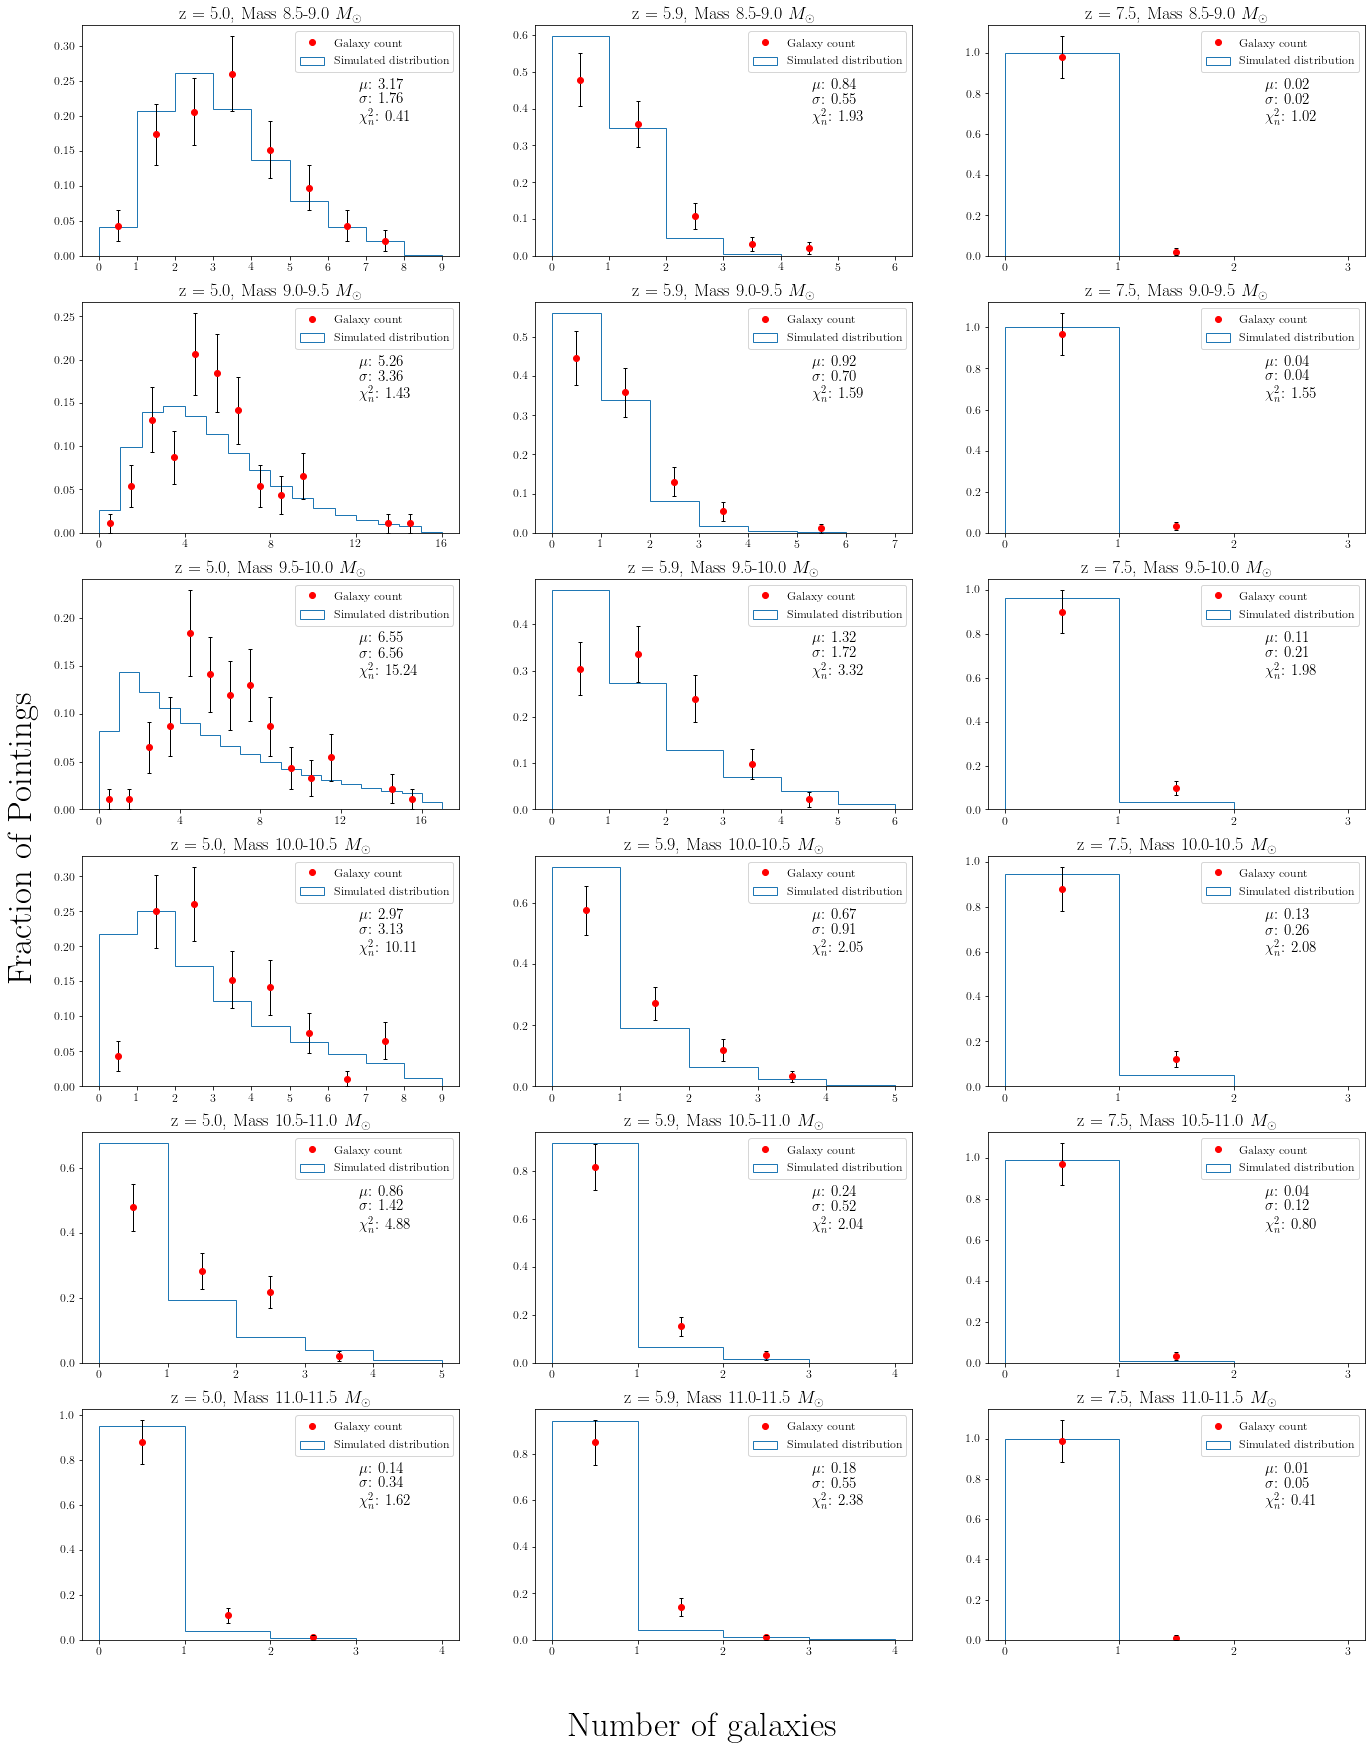

In [35]:
%matplotlib inline
# change x-ticks to be in the middle of the histogram
# Generate all plots
plt.rcParams.update({'font.size': 12})
# %time
indices = [40,43,48,52,55,59]
masses = [8.5, 9.0, 9.5, 10.0, 10.5, 11.0]
indices=indices[3:]
print(len(indices)*len(masses),'panels. Expected time is {} s'.format(len(indices)*len(masses)*12.5))
fig, ax = plt.subplots(nrows=len(masses),ncols=len(indices), figsize = (23,29.7))
# fig.set(xlabel='Number of Galaxies', ylabel='Fraction of points')
plt.rcParams.update({'font.size': 35})
fig.text(0.5, 0.08, 'Number of galaxies', ha='center')
fig.text(0.08, 0.5, 'Fraction of Pointings', va='center', rotation='vertical')
plt.rcParams.update({'font.size': 15})
k=0
for i in indices:
    j=0
    for m in masses:
        z_val = z_vals[i]
        dz_val = dz_vals[i]
        x, vals, counts, err, g, counts_nn, mean, var, num_gal = num_gals(z_val, dz_val, m, plot=False, close=False)
        me=np.mean(g)
        std=np.std(g)
        g = g[g <= max(vals)+1]
        y, bin_edges, patch=ax[j][k].hist(g+0.1,bins=np.arange(max(vals)+3),range=(0,max(vals)+3),density=1,histtype='step', label='Simulated distribution')
        x_val=np.arange(len(y))
        count_f=np.zeros(len(y))
        chi2=0
        for t in range(len(y)):
            if x_val[t] in vals:
                q=np.where(vals==x_val[t])
                chi2+=(counts[q]-y[t])**2/err[q]**2
        chi2=chi2/len(vals)
        d = {r'$\mu$:': mean,
             r'$\sigma$:': np.sqrt(var),
             r'$\chi^2_n$:': chi2[0] ,
            }        
        text = nice_string_output(d, extra_spacing=2, decimals=2)
        add_text_to_ax(0.735, 0.77, text, ax[j][k], fontsize=15)
#         add_text_to_ax(0.7, 0.7, text, ax[k][j], fontsize=25)
        ax[j][k].plot(vals+0.5,counts, 'ro', label='Galaxy count') 
        ax[j][k].errorbar(vals+0.5,counts, yerr=err, c = 'k', elinewidth = 1, \
                       capsize = 2, ls = 'none')
        if max(vals)>=10:
            xtick=np.arange(0,max(vals)+3,4)
        else:
            xtick=np.arange(0,max(vals)+3,1)
        z_val = z_vals[i]
        ax[j][k].set(xticks=xtick, title="z = %.1f, Mass %.1f-%.1f "r"$M_{\odot}$" % (np.round(z_val,2), m, m+0.5))
#         ax[k][j].set(xticks=xtick, xlabel="Number of Galaxies", ylabel="Fraction of Pointings", title="z = %.1f, Mass %.1f-%.1f "r"$M_{\odot}$" % (np.round(z_val,2), m, m+0.5))
        ax[j][k].legend(loc=1, prop={'size': 12})
        j+=1
    k+=1
# fig.tight_layout()
duration = 250  # milliseconds
freq = 500  # Hz
winsound.Beep(freq, duration)
plt.savefig('test_cosmos_full_2.pdf')

9 panels. Expected time is 112.5 s


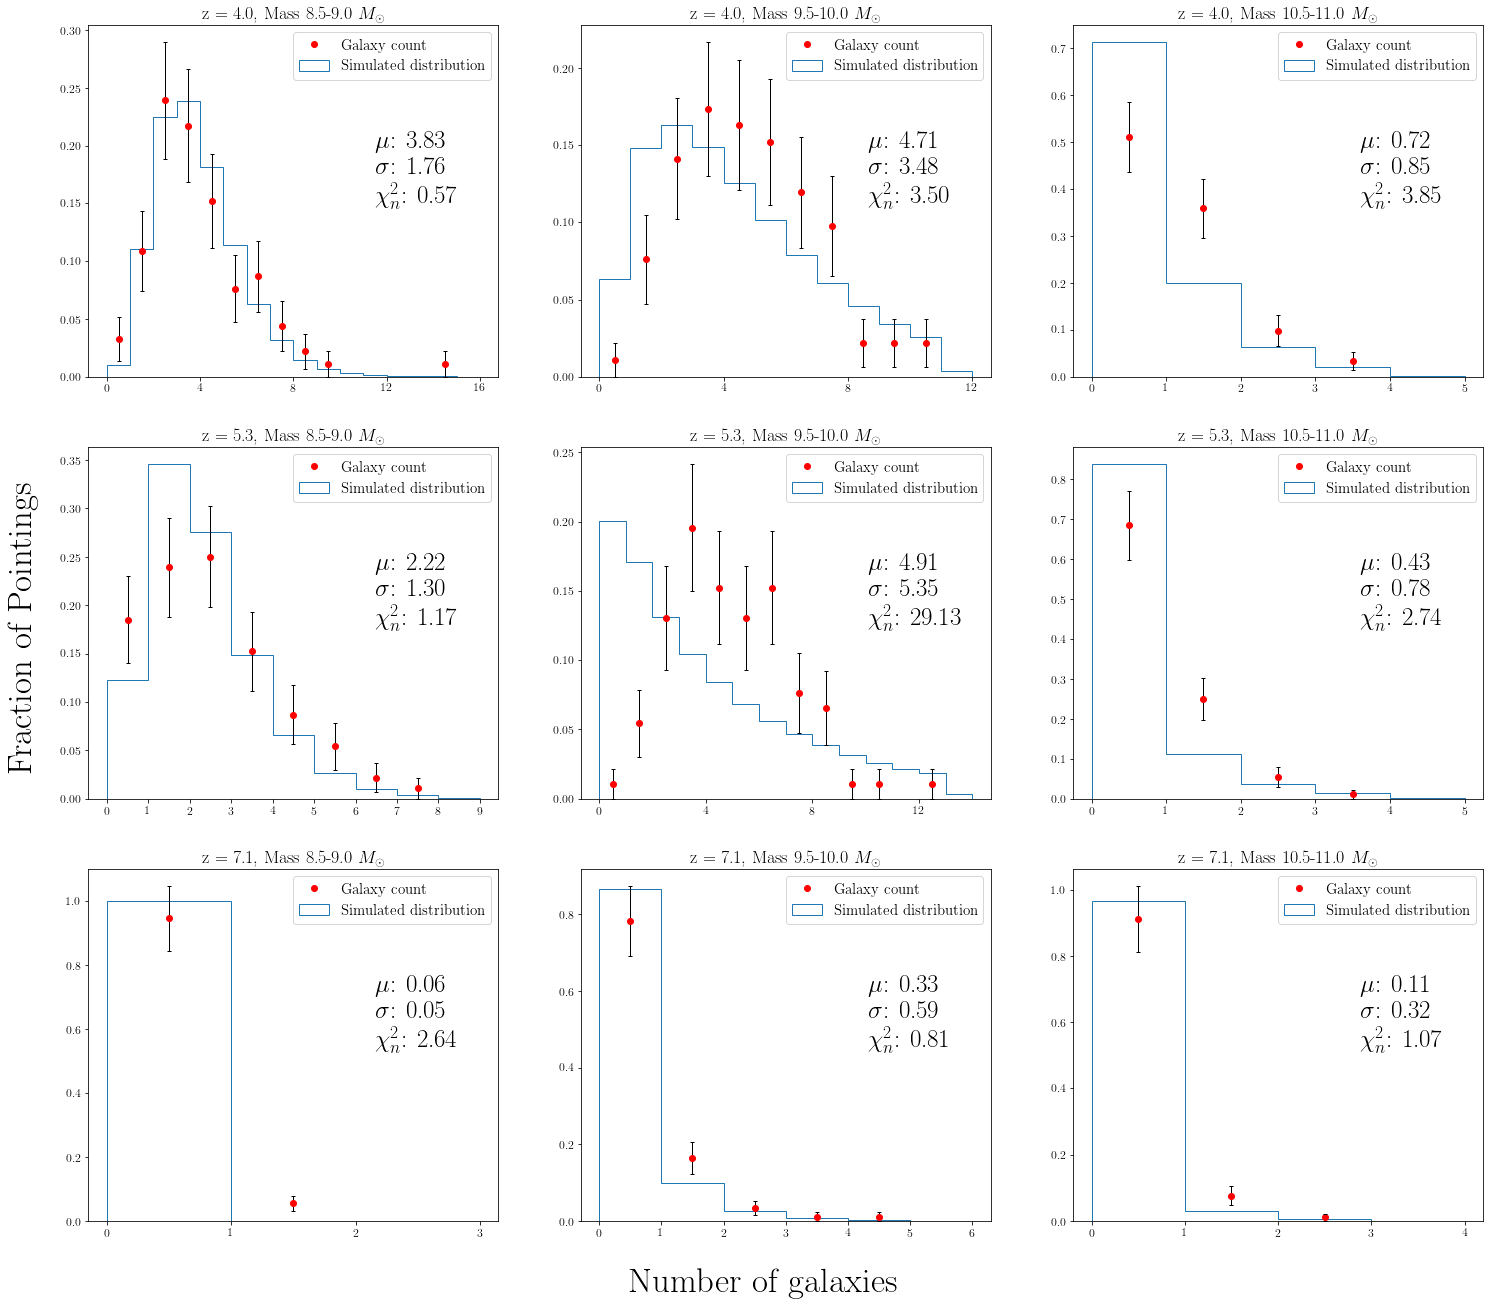

In [39]:
%matplotlib inline
# change x-ticks to be in the middle of the histogram
# Generate all plots
plt.rcParams.update({'font.size': 12})
# %time
masses = [8.5, 9.0, 9.5, 10.0, 10.5, 11.0]
masses=masses[::2]
indices=[48,53,58]
print(len(indices)*len(masses),'panels. Expected time is {} s'.format(len(indices)*len(masses)*12.5))
fig, ax = plt.subplots(nrows=len(indices),ncols=len(masses), figsize = (25,22))
# fig.set(xlabel='Number of Galaxies', ylabel='Fraction of points')
plt.rcParams.update({'font.size': 35})
fig.text(0.5, 0.08, 'Number of galaxies', ha='center')
fig.text(0.08, 0.5, 'Fraction of Pointings', va='center', rotation='vertical')
plt.rcParams.update({'font.size': 15})
k=0
for i in indices:
    j=0
    for m in masses:
        z_val = z_vals[i]
        dz_val = dz_vals[i]
        x, vals, counts, err, g, counts_nn, mean, var, num_gal = num_gals(z_val, dz_val, m, plot=False, close=False)
        me=np.mean(g)
        std=np.std(g)
        g = g[g <= max(vals)+1]
        y, bin_edges, patch=ax[k][j].hist(g,bins=np.arange(max(vals)+3),range=(0,max(vals)+3),density=1,histtype='step', label='Simulated distribution')
        x_val=np.arange(len(y))
        count_f=np.zeros(len(y))
        chi2=0
        for t in range(len(y)):
            if x_val[t] in vals:
                q=np.where(vals==x_val[t])
                chi2+=(counts[q]-y[t])**2/err[q]**2
        chi2=chi2/len(vals)
        d = {r'$\mu$:': mean,
             r'$\sigma$:': np.sqrt(var),
             r'$\chi^2_n$:': chi2[0] ,
            }        
        text = nice_string_output(d, extra_spacing=2, decimals=2)
#         add_text_to_ax(0.77, 0.75, text, ax[k][j], fontsize=15)
        add_text_to_ax(0.7, 0.7, text, ax[k][j], fontsize=25)
        ax[k][j].plot(vals+0.5,counts, 'ro', label='Galaxy count') 
        ax[k][j].errorbar(vals+0.5,counts, yerr=err, c = 'k', elinewidth = 1, \
                       capsize = 2, ls = 'none')
        if max(vals)>=10:
            xtick=np.arange(0,max(vals)+3,4)
        else:
            xtick=np.arange(0,max(vals)+3,1)
        z_val = z_vals[i]
        ax[k][j].set(xticks=xtick, title="z = %.1f, Mass %.1f-%.1f "r"$M_{\odot}$" % (np.round(z_val,2), m, m+0.5))
#         ax[k][j].set(xticks=xtick, xlabel="Number of Galaxies", ylabel="Fraction of Pointings", title="z = %.1f, Mass %.1f-%.1f "r"$M_{\odot}$" % (np.round(z_val,2), m, m+0.5))
        ax[k][j].legend(prop={'size': 15})
        j+=1
    k+=1
# fig.tight_layout()
duration = 250  # milliseconds
freq = 500  # Hz
winsound.Beep(freq, duration)
plt.savefig('test_cosmos_small.pdf')